# Post-Training Quantization

Task as defined by Joosep:
``I would perhaps start with post-training quantization``.
either in tensorflow: https://www.tensorflow.org/model_optimization/guide/quantization/post_training

or on top of the exported ONNX model:
https://onnxruntime.ai/docs/performance/model-optimizations/quantization.html

``you need to set up a basic code that performs post-training quantization on a trained model, evaluated the speed and loss of physics performance
``

## Post Training quantization in TensorFlow 

Post-training quantization is a conversion technique that can reduce model size while also improving CPU and hardware accelerator latency, with little degradation in model accuracy.

### Optimization methods
There are several post-training quantization options to choose from. 

| Model Technique         | Benefits                            | Hardware                                    |
|-------------------------|------------------------------------|---------------------------------------------|
| Dynamic range quantization | 4x smaller, 2x-3x speedup       | CPU                                         |
| Full integer quantization  | 4x smaller, 3x+ speedup         | CPU, Edge TPU, Microcontrollers             |
| Float16 quantization      | 2x smaller, GPU acceleration   | CPU, GPU                                    |


The following decision tree can help determine which post-training quantization method is best for your use case:
![images_1](https://www.tensorflow.org/static/lite/performance/images/optimization.jpg)

We will start with `Dynamic Range Quantization` because it provides reduced memory usage and faster computation without you having to provide a representative dataset for calibration. This type of quantization, statically quantizes only the weights from floating point to integer at conversion time, which provides 8-bits of precision:
```python
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quant_model = converter.convert()
```
To further reduce latency during inference, "dynamic-range" operators dynamically quantize activations based on their range to 8-bits and perform computations with 8-bit weights and activations. This optimization provides latencies close to fully fixed-point inferences. However, the outputs are still stored using floating point so the increased speed of dynamic-range ops is less than a full fixed-point computation.


**Quantization involves reducing the precision of the weights and activations in a model, typically from 32-bit floating point values to 8-bit integers.**

In [1]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
from tensorflow import keras
import numpy as np
import pathlib
import joblib


import h5py
import pickle
import pandas as pd

import sys

2023-10-20 11:01:55.012802: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-20 11:01:55.189127: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-20 11:01:55.189158: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-20 11:01:55.190398: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-20 11:01:55.373171: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-20 11:01:55.375127: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [ ]:
!wget https://huggingface.co/jpata/particleflow/blob/clic_clusters_v1.6/opt-96-5.346523.pkl

In [ ]:
!wget https://huggingface.co/jpata/particleflow/blob/clic_clusters_v1.6/weights-96-5.346523.hdf5

### Reading the HDF5 Files

Method I

In [2]:
with h5py.File('weights-96-5.346523.hdf5', 'r') as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    a_group_key = list(f.keys())[0]
    
    # get the object type for a_group_key: usually group or dataset
    print(type(f[a_group_key])) 


Keys: <KeysViewHDF5 ['cg_id_0', 'cg_id_1', 'cg_id_2', 'cg_id_3', 'cg_id_4', 'cg_id_5', 'cg_reg_0', 'cg_reg_1', 'cg_reg_2', 'cg_reg_3', 'cg_reg_4', 'cg_reg_5', 'input_encoding_clic', 'node_encoding', 'normalization', 'output_decoding', 'top_level_model_weights']>
<class 'h5py._hl.group.Group'>


Method II

In [3]:
f = h5py.File('weights-96-5.346523.hdf5')

# Studying the structure of the file by printing what HDF5 groups are present

for key in f.keys():
    print(key) #Names of the root level object names in HDF5 file - can be groups or datasets.
    print(type(f[key])) # get the object type: usually group or dataset

cg_id_0
<class 'h5py._hl.group.Group'>
cg_id_1
<class 'h5py._hl.group.Group'>
cg_id_2
<class 'h5py._hl.group.Group'>
cg_id_3
<class 'h5py._hl.group.Group'>
cg_id_4
<class 'h5py._hl.group.Group'>
cg_id_5
<class 'h5py._hl.group.Group'>
cg_reg_0
<class 'h5py._hl.group.Group'>
cg_reg_1
<class 'h5py._hl.group.Group'>
cg_reg_2
<class 'h5py._hl.group.Group'>
cg_reg_3
<class 'h5py._hl.group.Group'>
cg_reg_4
<class 'h5py._hl.group.Group'>
cg_reg_5
<class 'h5py._hl.group.Group'>
input_encoding_clic
<class 'h5py._hl.group.Group'>
node_encoding
<class 'h5py._hl.group.Group'>
normalization
<class 'h5py._hl.group.Group'>
output_decoding
<class 'h5py._hl.group.Group'>
top_level_model_weights
<class 'h5py._hl.group.Group'>


In [4]:

# Open the HDF5 file
with h5py.File('weights-96-5.346523.hdf5', 'r') as file:
    # Loop through the keys and read the data
    for key in file.keys():
#         print(f"Key: {key}")

        # Check if the key refers to a group
        if isinstance(file[key], h5py.Group):
            # Access the group and print its keys
            group = file[key]
            print(f"Keys within {key}: {list(group.keys())}")

#             for subkey in group.keys():
#                 data = group[subkey][()]
#                 print(f"Data in {subkey}:")
#                 print(data)
            
        
            

Keys within cg_id_0: ['cg_id_0', 'cg_id_0_ffn_dist_dense_0', 'cg_id_0_ffn_dist_dense_1', 'cg_id_0_ffn_dist_dense_2', 'cg_id_0_ffn_dist_dense_3']
Keys within cg_id_1: ['cg_id_1', 'cg_id_1_ffn_dist_dense_0', 'cg_id_1_ffn_dist_dense_1', 'cg_id_1_ffn_dist_dense_2', 'cg_id_1_ffn_dist_dense_3']
Keys within cg_id_2: ['cg_id_2', 'cg_id_2_ffn_dist_dense_0', 'cg_id_2_ffn_dist_dense_1', 'cg_id_2_ffn_dist_dense_2', 'cg_id_2_ffn_dist_dense_3']
Keys within cg_id_3: ['cg_id_3', 'cg_id_3_ffn_dist_dense_0', 'cg_id_3_ffn_dist_dense_1', 'cg_id_3_ffn_dist_dense_2', 'cg_id_3_ffn_dist_dense_3']
Keys within cg_id_4: ['cg_id_4', 'cg_id_4_ffn_dist_dense_0', 'cg_id_4_ffn_dist_dense_1', 'cg_id_4_ffn_dist_dense_2', 'cg_id_4_ffn_dist_dense_3']
Keys within cg_id_5: ['cg_id_5', 'cg_id_5_ffn_dist_dense_0', 'cg_id_5_ffn_dist_dense_1', 'cg_id_5_ffn_dist_dense_2', 'cg_id_5_ffn_dist_dense_3']
Keys within cg_reg_0: ['cg_reg_0', 'cg_reg_0_ffn_dist_dense_0', 'cg_reg_0_ffn_dist_dense_1', 'cg_reg_0_ffn_dist_dense_2', 'cg_reg_

In [5]:
# Open the HDF5 file
with h5py.File('weights-96-5.346523.hdf5', 'r') as file:
    # Access the group 'cg_id_0'
    group_cg_id_0 = file['cg_id_0']
    
    # List the keys within the group
    keys_in_cg_id_0 = list(group_cg_id_0.keys())
    print(f"Keys within cg_id_0: {keys_in_cg_id_0}")
    
    #Choose a subkey
    subkey='cg_id_0'
    
    subgroup = group_cg_id_0[subkey]
    
#     print(subgroup)
    
    keys_in_subgroup = list(subgroup.keys())
    print(f"Keys within {subkey}: {keys_in_subgroup}")

    

Keys within cg_id_0: ['cg_id_0', 'cg_id_0_ffn_dist_dense_0', 'cg_id_0_ffn_dist_dense_1', 'cg_id_0_ffn_dist_dense_2', 'cg_id_0_ffn_dist_dense_3']
Keys within cg_id_0: ['cg_id_0_layernorm1', 'cg_id_0_msg_0', 'cg_id_0_msg_1', 'message_building_layer_lsh']


## Reading files within the subgroup

In [ ]:
with h5py.File('weights-96-5.346523.hdf5', 'r') as file:
    # Access the subgroup 'cg_id_0_ffn_dist_dense_0'
    subgroup_cg_id_0_ffn_dist_dense_0 = file['cg_id_0']['cg_id_0_ffn_dist_dense_0']
    
    # List the keys within the subgroup
    keys_in_subgroup = list(subgroup_cg_id_0_ffn_dist_dense_0.keys())
    print(f"Keys within cg_id_0_ffn_dist_dense_0: {keys_in_subgroup}")
    
    # Access and print data within the subgroup
    for subkey in keys_in_subgroup:
        data = subgroup_cg_id_0_ffn_dist_dense_0[subkey][()]
        print(f"Data in {subkey}:")
        print(data)

##### applying the post training quantization on the weights(bais and Kernel) stored in a subsubgroup of the HDF5 file.

In [ ]:
# Open the HDF5 file
with h5py.File('weights-96-5.346523.hdf5', 'r') as file:
    # Access the subgroup 'cg_id_0_ffn_dist_dense_0'
    subgroup_cg_id_0_ffn_dist_dense_0 = file['cg_id_0']['cg_id_0_ffn_dist_dense_0']
    
    # Load the weights (bias and kernel)
    bias = subgroup_cg_id_0_ffn_dist_dense_0['bias:0'][()]  # Load bias
    kernel = subgroup_cg_id_0_ffn_dist_dense_0['kernel:0'][()]  # Load kernel
    
    # Apply post-training quantization
    # Apply post-training quantization to the weights
    quantized_bias = tf.quantization.fake_quant_with_min_max_args(
        bias, min=-10, max=10, num_bits=8)
    quantized_kernel = tf.quantization.fake_quant_with_min_max_args(
        kernel, min=-10, max=10, num_bits=8)

In [ ]:
# Calculate the sizes
original_bias_size = sys.getsizeof(bias)
original_kernel_size = sys.getsizeof(kernel)
quantized_bias_size = sys.getsizeof(quantized_bias)
quantized_kernel_size = sys.getsizeof(quantized_kernel)


In [ ]:
# Print the sizes
print(f"Output with Fake Quantization")
print(f"=====================================")
print(f"Original Bias Size: {original_bias_size} bytes")
print(f"Original Kernel Size: {original_kernel_size} bytes")
print(f"Quantized Bias Size: {quantized_bias_size} bytes")
print(f"Quantized Kernel Size: {quantized_kernel_size} bytes")

# Full integer Quantization

In [ ]:
# Define a function to perform full integer quantization
def full_integer_quantization(weights, num_bits=8):
    # Determine the range of values
    min_val = np.min(weights)
    max_val = np.max(weights)
    
    # Define the quantization range
    q_min = 0
    q_max = 2**num_bits - 1
    
    # Scale and quantize the weights
    scale = (max_val - min_val) / (q_max - q_min)
    zero_point = q_min - min_val / scale
    
    quantized_weights = np.round(weights / scale + zero_point)
    return quantized_weights.astype(np.uint8)


# Open the HDF5 file
with h5py.File('weights-96-5.346523.hdf5', 'r') as file:
    # Access the subgroup 'cg_id_0_ffn_dist_dense_0'
    subgroup_cg_id_0_ffn_dist_dense_0 = file['cg_id_0']['cg_id_0_ffn_dist_dense_0']
    
    # Load the weights (bias and kernel)
    bias = subgroup_cg_id_0_ffn_dist_dense_0['bias:0'][()]  # Load bias
    kernel = subgroup_cg_id_0_ffn_dist_dense_0['kernel:0'][()]  # Load kernel
    
    # Apply full integer quantization to the weights
    quantized_bias = full_integer_quantization(bias)
    quantized_kernel = full_integer_quantization(kernel)
    
    
# Calculate the sizes
original_bias_size = sys.getsizeof(bias)
original_kernel_size = sys.getsizeof(kernel)
quantized_bias_size = sys.getsizeof(quantized_bias)
quantized_kernel_size = sys.getsizeof(quantized_kernel)


# Print the sizes
print(f"Output with Full integer Quantization")
print(f"=====================================")
print(f"Original Bias Size: {original_bias_size} bytes")
print(f"Original Kernel Size: {original_kernel_size} bytes")
print(f"Quantized Bias Size: {quantized_bias_size} bytes")
print(f"Quantized Kernel Size: {quantized_kernel_size} bytes")

# Calculate the reduction factor
reduction_factor_bias = original_bias_size / quantized_bias_size
reduction_factor_kernel = original_kernel_size / quantized_kernel_size
print(f"Reduction Factor for Bias: {reduction_factor_bias}")
print(f"Reduction Factor for Kernel: {reduction_factor_kernel}")


# Dynamic Range Quantization

In [ ]:
import h5py
import tensorflow as tf

# Define a function to apply dynamic range quantization
def dynamic_range_quantization(weights):
    # Define the quantization range dynamically based on the weights
    min_val = tf.reduce_min(weights)
    max_val = tf.reduce_max(weights)
    num_bits = 8  # Define the number of bits for quantization

    # Compute the scale and zero point
    scale = (max_val - min_val) / ((2 ** num_bits) - 1)
    zero_point = tf.round(-min_val / scale)

    # Apply quantization and dequantization
    quantized_weights = tf.round(weights / scale) - zero_point
    dequantized_weights = (quantized_weights + zero_point) * scale

    return dequantized_weights

# Open the HDF5 file
with h5py.File('weights-96-5.346523.hdf5', 'r') as file:
    # Access the subgroup 'cg_id_0_ffn_dist_dense_0'
    subgroup_cg_id_0_ffn_dist_dense_0 = file['cg_id_0']['cg_id_0_ffn_dist_dense_0']
    
    # Load the weights (bias and kernel)
    bias = subgroup_cg_id_0_ffn_dist_dense_0['bias:0'][()]  # Load bias
    kernel = subgroup_cg_id_0_ffn_dist_dense_0['kernel:0'][()]  # Load kernel

    # Apply dynamic range quantization to the weights
    quantized_bias = dynamic_range_quantization(bias)
    quantized_kernel = dynamic_range_quantization(kernel)

    
# Calculate the sizes
original_bias_size = sys.getsizeof(bias)
original_kernel_size = sys.getsizeof(kernel)
quantized_bias_size = sys.getsizeof(quantized_bias)
quantized_kernel_size = sys.getsizeof(quantized_kernel)


# Print the sizes
print(f"Output with Dynamic Range Quantization")
print(f"=====================================")
print(f"Original Bias Size: {original_bias_size} bytes")
print(f"Original Kernel Size: {original_kernel_size} bytes")
print(f"Quantized Bias Size: {quantized_bias_size} bytes")
print(f"Quantized Kernel Size: {quantized_kernel_size} bytes")

# Calculate the reduction factor
reduction_factor_bias = original_bias_size / quantized_bias_size
reduction_factor_kernel = original_kernel_size / quantized_kernel_size
print(f"Reduction Factor for Bias: {reduction_factor_bias}")
print(f"Reduction Factor for Kernel: {reduction_factor_kernel}")


# Float 16 quantization

In [6]:
import h5py
import tensorflow as tf

# Define a function to apply Float16 quantization
def float16_quantization(weights):
    return tf.dtypes.cast(weights, tf.float16)

# Open the HDF5 file
with h5py.File('weights-96-5.346523.hdf5', 'r') as file:
    # Access the subgroup 'cg_id_0_ffn_dist_dense_0'
    subgroup_cg_id_0_ffn_dist_dense_0 = file['cg_id_0']['cg_id_0_ffn_dist_dense_0']
    
    # Load the weights (bias and kernel)
    bias = subgroup_cg_id_0_ffn_dist_dense_0['bias:0'][()]  # Load bias
    kernel = subgroup_cg_id_0_ffn_dist_dense_0['kernel:0'][()]  # Load kernel

    # Apply Float16 quantization to the weights
    float16_bias = float16_quantization(bias)
    float16_kernel = float16_quantization(kernel)

    
# Calculate the sizes
original_bias_size = sys.getsizeof(bias)
original_kernel_size = sys.getsizeof(kernel)
quantized_bias_size = sys.getsizeof(float16_bias)
quantized_kernel_size = sys.getsizeof(float16_kernel)


# Print the sizes
print(f"Output with Float 16 Quantization")
print(f"=====================================")
print(f"Original Bias Size: {original_bias_size} bytes")
print(f"Original Kernel Size: {original_kernel_size} bytes")
print(f"Quantized Bias Size: {quantized_bias_size} bytes")
print(f"Quantized Kernel Size: {quantized_kernel_size} bytes")

# Calculate the reduction factor
reduction_factor_bias = original_bias_size / quantized_bias_size
reduction_factor_kernel = original_kernel_size / quantized_kernel_size
print(f"Reduction Factor for Bias: {reduction_factor_bias}")
print(f"Reduction Factor for Kernel: {reduction_factor_kernel}")


Output with Float 16 Quantization
Original Bias Size: 368 bytes
Original Kernel Size: 65664 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 2.1904761904761907
Reduction Factor for Kernel: 390.85714285714283


In [7]:
print(kernel)


array([[ 0.31398082, -0.5096557 , -0.03505608, ...,  0.08097732,
         0.19537257, -0.35680908],
       [-0.04176841,  0.10870415,  0.01572619, ...,  0.05416466,
         0.12002812, -0.62530637],
       [-0.07226437, -0.28455225,  0.06761416, ...,  0.11163151,
         0.09915844, -0.23784722],
       ...,
       [ 0.05049501, -0.03838195,  0.08743014, ...,  0.05069735,
         0.1369824 ,  0.58052385],
       [ 0.1408932 ,  0.16768245, -0.09721825, ...,  0.05845559,
         0.0926805 , -0.03045342],
       [ 0.16930693,  0.17753285, -0.04727688, ...,  0.1146686 ,
        -0.2299448 , -0.12432736]], dtype=float32)

In [8]:
print(float16_kernel)

<tf.Tensor: shape=(256, 64), dtype=float16, numpy=
array([[ 0.314  , -0.51   , -0.03506, ...,  0.081  ,  0.1953 , -0.3567 ],
       [-0.04178,  0.1087 ,  0.01573, ...,  0.05417,  0.12006, -0.6255 ],
       [-0.07227, -0.2847 ,  0.0676 , ...,  0.11163,  0.0992 , -0.2378 ],
       ...,
       [ 0.0505 , -0.0384 ,  0.0874 , ...,  0.0507 ,  0.137  ,  0.5806 ],
       [ 0.1409 ,  0.1677 , -0.0972 , ...,  0.05844,  0.09265, -0.03046],
       [ 0.1693 ,  0.1775 , -0.04727, ...,  0.1147 , -0.23   , -0.1243 ]],
      dtype=float16)>

Issue: to conver the given tensorflow output in the tensor to array
 Use `tf.make_tensor_proto` first on the tensor output and then use `tf.make_ndarray`.
 
 Example:
 
 
 ```python
float16_kernel_array_proto = tf.make_tensor_proto(float16_kernel)
float16_kernel_array = tf.make_ndarray(float16_kernel_array_proto)
float16_kernel_array.shape

```

In [9]:
float16_kernel_array_proto = tf.make_tensor_proto(float16_kernel)
float16_kernel_array = tf.make_ndarray(float16_kernel_array_proto)
float16_kernel_array.shape

(256, 64)

### 2D histogram before and after quantization

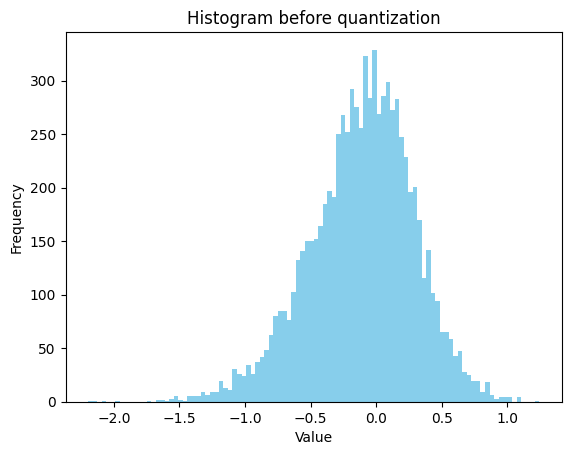

In [83]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(kernel.flatten(), bins=100, color='skyblue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram before quantization')
plt.show()

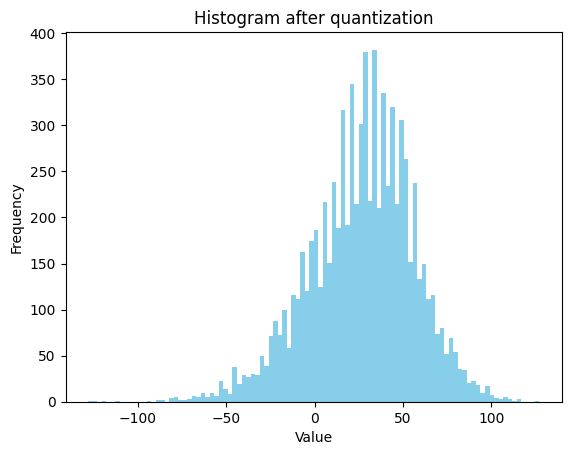

In [82]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(float16_kernel_array.flatten(), bins=100, color='skyblue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram after quantization')
plt.show()

### 2D histogram Correlation Plot

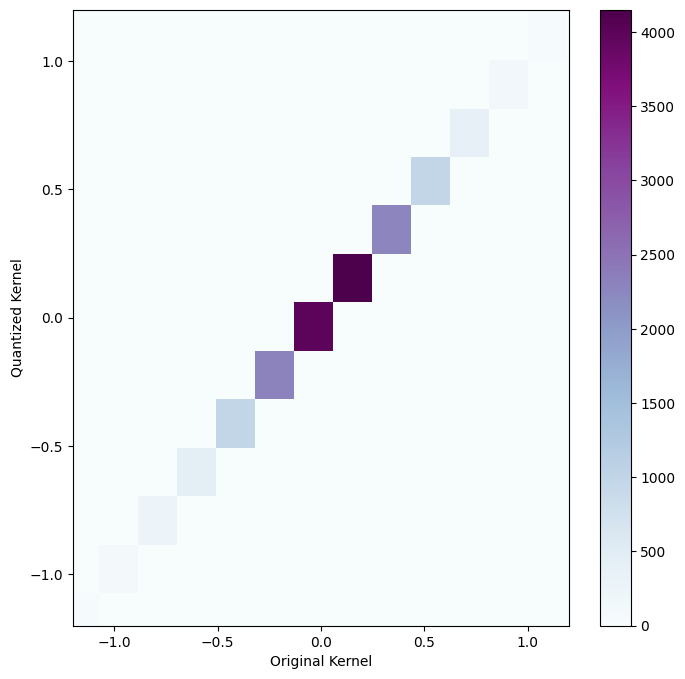

In [12]:
# Calculate the correlation between original and quantized kernel
correlation = tf.reduce_sum(tf.multiply(kernel, float16_kernel)).numpy()

# Plotting the 2D histogram
plt.figure(figsize=(8, 8))
plt.hist2d(kernel.flatten(), float16_kernel_array.flatten(), bins=(50, 50), cmap='BuPu')
plt.colorbar()

# Setting x and y lim
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)

plt.xlabel('Original Kernel')
plt.ylabel('Quantized Kernel')
# plt.title('2D Correlation Histogram')
plt.show()

# 8-bit quantization

In [21]:
import h5py
import tensorflow as tf
import sys

# Define a function to apply Int8 quantization
def int8_quantization(weights):
    min_val = tf.reduce_min(weights)
    max_val = tf.reduce_max(weights)
    quantized_weights = tf.quantization.quantize(weights, min_val, max_val, tf.qint8)
    return quantized_weights

# Open the HDF5 file
with h5py.File('weights-96-5.346523.hdf5', 'r') as file:
    # Access the subgroup 'cg_id_0_ffn_dist_dense_0'
    subgroup_cg_id_0_ffn_dist_dense_0 = file['cg_id_0']['cg_id_0_ffn_dist_dense_0']
    
    # Load the weights (bias and kernel)
    bias = subgroup_cg_id_0_ffn_dist_dense_0['bias:0'][()]  # Load bias
    kernel = subgroup_cg_id_0_ffn_dist_dense_0['kernel:0'][()]  # Load kernel

    # Apply Int8 quantization to the weights
    int8_bias = int8_quantization(bias)
    int8_kernel = int8_quantization(kernel)

    
# Calculate the sizes
original_bias_size = sys.getsizeof(bias)
original_kernel_size = sys.getsizeof(kernel)
quantized_bias_size = sys.getsizeof(int8_bias)
quantized_kernel_size = sys.getsizeof(int8_kernel)


# Print the sizes
print(f"Output with Int8 Quantization")
print(f"=====================================")
print(f"Original Bias Size: {original_bias_size} bytes")
print(f"Original Kernel Size: {original_kernel_size} bytes")
print(f"Quantized Bias Size: {quantized_bias_size} bytes")
print(f"Quantized Kernel Size: {quantized_kernel_size} bytes")

# Calculate the reduction factor
reduction_factor_bias = original_bias_size / quantized_bias_size
reduction_factor_kernel = original_kernel_size / quantized_kernel_size
print(f"Reduction Factor for Bias: {reduction_factor_bias}")
print(f"Reduction Factor for Kernel: {reduction_factor_kernel}")


Output with Int8 Quantization
Original Bias Size: 368 bytes
Original Kernel Size: 65664 bytes
Quantized Bias Size: 64 bytes
Quantized Kernel Size: 64 bytes
Reduction Factor for Bias: 5.75
Reduction Factor for Kernel: 1026.0


In [18]:
print(kernel.shape)

(256, 64)

In [23]:
 kernel.dtype


dtype('float32')

In [28]:
int8_kernel[0].shape

TensorShape([256, 64])

In [26]:
print(f"Data type of int8_kernel: {int8_kernel[0].dtype}")


Data type of int8_kernel: <dtype: 'qint8'>


In [29]:
int8_kernel_proto = tf.make_tensor_proto(int8_kernel[0])
int8_kernel_array = tf.make_ndarray(int8_kernel_proto)
int8_kernel_array.shape

(256, 64)

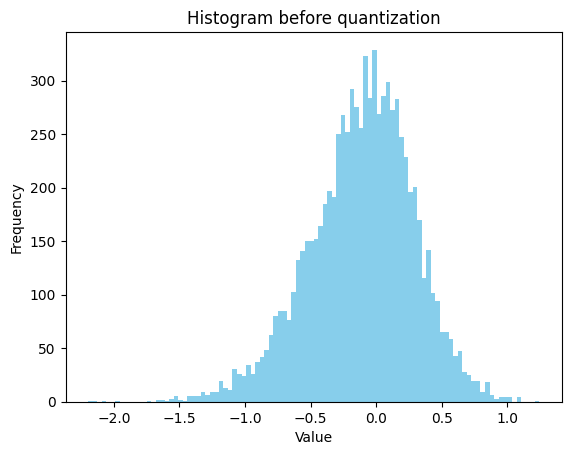

In [85]:
### 2D histogram before and after quantization
import numpy as np
import matplotlib.pyplot as plt

plt.hist(kernel.flatten(), bins=100, color='skyblue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram before quantization')
plt.show()



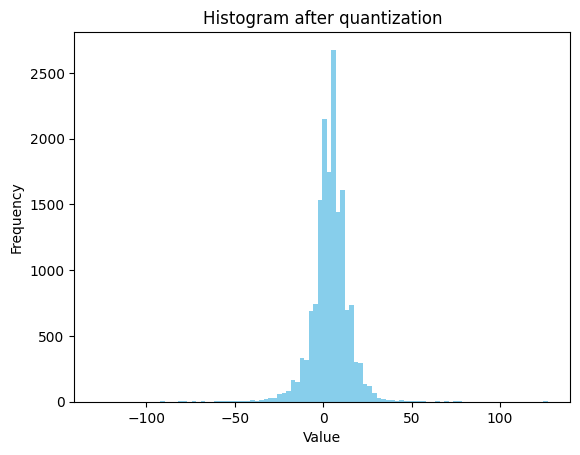

In [87]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(int8_kernel_array.flatten(), bins=100, color='skyblue')
# plt.xlim(-1,1)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram after quantization')
plt.show()

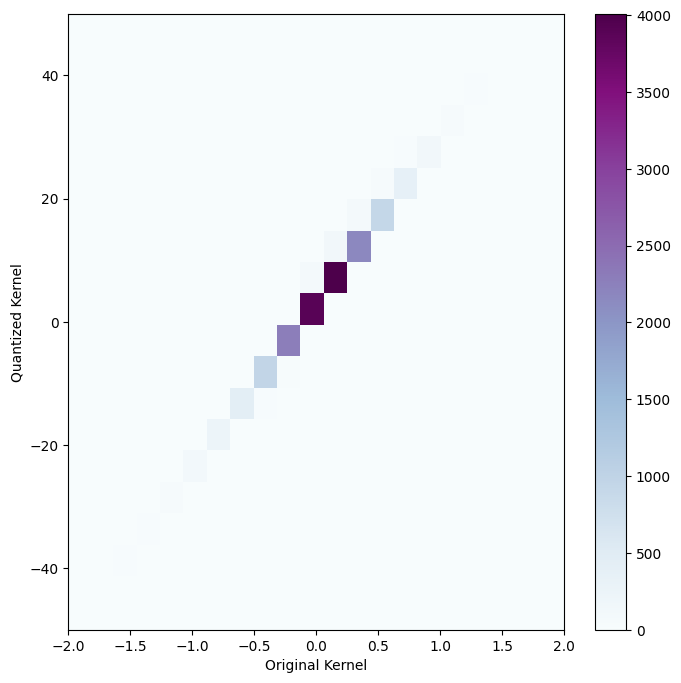

In [49]:
# Calculate the correlation between original and quantized kernel
# correlation = tf.reduce_sum(tf.multiply(kernel, int8_kernel)).numpy()

# Plotting the 2D histogram
plt.figure(figsize=(8, 8))
plt.hist2d(kernel.flatten(), int8_kernel_array.flatten(), bins=(50, 50), cmap='BuPu')
plt.colorbar()

# Setting x and y lim
plt.xlim(-2,2)
plt.ylim(-50,50)

plt.xlabel('Original Kernel')
plt.ylabel('Quantized Kernel')
# plt.title('2D Correlation Histogram')
plt.show()

# 4-bit quantization


In [54]:
import h5py
import numpy as np

# Define a function to apply 4-bit quantization
def int4_quantization(weights):
    min_val = np.min(weights)
    max_val = np.max(weights)
    scale = (max_val - min_val) / 15  # 4-bit range: 0-15
    quantized_weights = np.round((weights - min_val) / scale)
    return quantized_weights

# Open the HDF5 file
with h5py.File('weights-96-5.346523.hdf5', 'r') as file:
    # Access the subgroup 'cg_id_0_ffn_dist_dense_0'
    subgroup_cg_id_0_ffn_dist_dense_0 = file['cg_id_0']['cg_id_0_ffn_dist_dense_0']
    
    # Load the weights (bias and kernel)
    bias = subgroup_cg_id_0_ffn_dist_dense_0['bias:0'][()]  # Load bias
    kernel = subgroup_cg_id_0_ffn_dist_dense_0['kernel:0'][()]  # Load kernel

    # Apply 4-bit quantization to the weights
    int4_bias = int4_quantization(bias)
    int4_kernel = int4_quantization(kernel)

# Calculate the sizes
original_bias_size = bias.nbytes
original_kernel_size = kernel.nbytes
quantized_bias_size = int4_bias.nbytes
quantized_kernel_size = int4_kernel.nbytes

# Print the sizes
print(f"Output with 4-bit Quantization")
print(f"=====================================")
print(f"Original Bias Size: {original_bias_size} bytes")
print(f"Original Kernel Size: {original_kernel_size} bytes")
print(f"Quantized Bias Size: {quantized_bias_size} bytes")
print(f"Quantized Kernel Size: {quantized_kernel_size} bytes")

# Calculate the reduction factor
reduction_factor_bias = original_bias_size / quantized_bias_size
reduction_factor_kernel = original_kernel_size / quantized_kernel_size
print(f"Reduction Factor for Bias: {reduction_factor_bias}")
print(f"Reduction Factor for Kernel: {reduction_factor_kernel}")


Output with 4-bit Quantization
Original Bias Size: 256 bytes
Original Kernel Size: 65536 bytes
Quantized Bias Size: 256 bytes
Quantized Kernel Size: 65536 bytes
Reduction Factor for Bias: 1.0
Reduction Factor for Kernel: 1.0


In [55]:
kernel

array([[ 0.31398082, -0.5096557 , -0.03505608, ...,  0.08097732,
         0.19537257, -0.35680908],
       [-0.04176841,  0.10870415,  0.01572619, ...,  0.05416466,
         0.12002812, -0.62530637],
       [-0.07226437, -0.28455225,  0.06761416, ...,  0.11163151,
         0.09915844, -0.23784722],
       ...,
       [ 0.05049501, -0.03838195,  0.08743014, ...,  0.05069735,
         0.1369824 ,  0.58052385],
       [ 0.1408932 ,  0.16768245, -0.09721825, ...,  0.05845559,
         0.0926805 , -0.03045342],
       [ 0.16930693,  0.17753285, -0.04727688, ...,  0.1146686 ,
        -0.2299448 , -0.12432736]], dtype=float32)

In [56]:
int4_kernel

array([[8., 7., 8., ..., 8., 8., 7.],
       [8., 8., 8., ..., 8., 8., 7.],
       [8., 7., 8., ..., 8., 8., 7.],
       ...,
       [8., 8., 8., ..., 8., 8., 9.],
       [8., 8., 8., ..., 8., 8., 8.],
       [8., 8., 8., ..., 8., 7., 8.]], dtype=float32)

# Issuses:
1. how the kernel quantization can give 390x in FP16 and Dynamic Range?
2. `There are a few files inside the ['cg_id_0']['cg_id_0'], do we need to work on those as well?`

We do not think so. These are files which does not contain any subgroup with that group.

3. The Files are not organised on this notebook, organise it. 
4. Work on the corelation plot for the int8.
5. Does output look gooD?
6. Does the produced file is an array?
7. I can understand how the bias quantization can give 2x, going from fp32 to fp16, but
I don’t understand really how the kernel quantization can give 390x?
8. calculate the reduction in size, and it’s huge. maybe the calculation is not correct,
because it’s a bit too huge, but nevertheless, the size will be reduced for sure.
4. what about the histograms with int8? if you make e.g. 200 bins in the range -1,1
I would say if you observe no distortion with fp16 or int8 in the distributions, and a
100x-1000x size reduction, we should be able to run the network with quantization and
get quite good results.
5. Am I doing correct so far?
6. Try to quantize the full model, run on data, check the difference in the output wrt.
the fp32 model.
7. quantized size is always kind of the same for bias and kernel. so I suspect the sys.getsize
is not really giving you the size of the data in memory, but rather the size of the data
container. Might be
8. how is the 390x factor calculated?
9. What you are calculating, is it’s like the size in memory?
10. if you have 1000 4-byte numbers (fp32), and then 1000 2-byte numbers (fp16), how
can there be anything else but a 2x size difference?
11. s the data in numpy arrays? maybe sys.getsizeof does not give correct results like this on
numpy arrays: https://stackoverflow.com/questions/11784329/python-memory-usage-
of-numpy-arrays
12. qint8 is some special quantized int8 format from tensorflow?
The code has been alsouploaded to the github, which can be easily access through this link,

## Applying on the whole Subgroup

### `cg_id_0`

#### Dynamic Range Quantization

In [63]:
# Define a function to apply Dynamic Range Quantization
def dynamic_range_quantization(weights):
    min_val = tf.reduce_min(weights)
    max_val = tf.reduce_max(weights)
    quantized_weights = tf.quantization.quantize(weights, min_val, max_val, tf.qint8)
    return quantized_weights

# Define a function to get the size of an object in bytes
def get_size(obj):
    return sys.getsizeof(obj)

# Open the HDF5 file
with h5py.File('weights-96-5.346523.hdf5', 'r') as file:
    # Access the group 'cg_id_0'
    group_cg_id_0 = file['cg_id_0']
    
    # Define a list of subgroup names
    subgroup_names = ['cg_id_0_ffn_dist_dense_0', 
                      'cg_id_0_ffn_dist_dense_1', 
                      'cg_id_0_ffn_dist_dense_2', 
                      'cg_id_0_ffn_dist_dense_3']
    
    for subgroup_name in subgroup_names:
        # Access the subgroup
        subgroup = group_cg_id_0[subgroup_name]
        
        # Load the weights (bias and kernel)
        bias = subgroup['bias:0'][()]  # Load bias
        kernel = subgroup['kernel:0'][()]  # Load kernel

        # Apply Dynamic Range Quantization to the weights
        quantized_bias = dynamic_range_quantization(bias)
        quantized_kernel = dynamic_range_quantization(kernel)

        # Print the sizes and reduction factors
        original_bias_size = get_size(bias)
        original_kernel_size = get_size(kernel)
        quantized_bias_size = get_size(quantized_bias)
        quantized_kernel_size = get_size(quantized_kernel)
        
        
        # Accumulate the sizes
        total_original_bias_size += original_bias_size
        total_original_kernel_size += original_kernel_size
        total_quantized_bias_size += quantized_bias_size
        total_quantized_kernel_size += quantized_kernel_size
        

        print(f"Output with Dynamic Range Quantization")
        print(f"=====================================")
        print(f"Subgroup Name: {subgroup_name}")
        print(f"Original Bias Size: {original_bias_size} bytes")
        print(f"Original Kernel Size: {original_kernel_size} bytes")
        print(f"Quantized Bias Size: {quantized_bias_size} bytes")
        print(f"Quantized Kernel Size: {quantized_kernel_size} bytes")
        print(f"Reduction Factor for Bias: {original_bias_size / quantized_bias_size}x")
        print(f"Reduction Factor for Kernel: {original_kernel_size / quantized_kernel_size}x")
        print('======================')
        print()

        
# Calculate total sizes
total_original_size = total_original_bias_size + total_original_kernel_size
total_quantized_size = total_quantized_bias_size + total_quantized_kernel_size
    
# Print the total sizes and reduction factor
print(f"Total Original Bias Size: {total_original_bias_size} bytes")
print(f"Total Original Kernel Size: {total_original_kernel_size} bytes")
print(f"Total Quantized Bias Size: {total_quantized_bias_size} bytes")
print(f"Total Quantized Kernel Size: {total_quantized_kernel_size} bytes")
print(f"Total Original Size: {total_original_size} bytes")
print(f"Total Quantized Size: {total_quantized_size} bytes")
print(f"Reduction Factor: {total_original_size / total_quantized_size}x")


Output with Dynamic Range Quantization
Subgroup Name: cg_id_0_ffn_dist_dense_0
Original Bias Size: 368 bytes
Original Kernel Size: 65664 bytes
Quantized Bias Size: 64 bytes
Quantized Kernel Size: 64 bytes
Reduction Factor for Bias: 5.75x
Reduction Factor for Kernel: 1026.0x

Output with Dynamic Range Quantization
Subgroup Name: cg_id_0_ffn_dist_dense_1
Original Bias Size: 368 bytes
Original Kernel Size: 16512 bytes
Quantized Bias Size: 64 bytes
Quantized Kernel Size: 64 bytes
Reduction Factor for Bias: 5.75x
Reduction Factor for Kernel: 258.0x

Output with Dynamic Range Quantization
Subgroup Name: cg_id_0_ffn_dist_dense_2
Original Bias Size: 368 bytes
Original Kernel Size: 16512 bytes
Quantized Bias Size: 64 bytes
Quantized Kernel Size: 64 bytes
Reduction Factor for Bias: 5.75x
Reduction Factor for Kernel: 258.0x

Output with Dynamic Range Quantization
Subgroup Name: cg_id_0_ffn_dist_dense_3
Original Bias Size: 624 bytes
Original Kernel Size: 32896 bytes
Quantized Bias Size: 64 bytes
Q

## Float 16 Quantization

In [59]:
# Define a function to apply Float16 quantization
def float16_quantization(weights):
    return tf.dtypes.cast(weights, tf.float16)

# Define a function to get the size of an object in bytes
def get_size(obj):
    return sys.getsizeof(obj)


total_original_bias_size = 0
total_original_kernel_size = 0
total_quantized_bias_size = 0
total_quantized_kernel_size = 0


# Open the HDF5 file
with h5py.File('weights-96-5.346523.hdf5', 'r') as file:
    # Access the group 'cg_id_0'
    group_cg_id_0 = file['cg_id_0']
    
    # Define a list of subgroup names
    subgroup_names = ['cg_id_0_ffn_dist_dense_0', 
                      'cg_id_0_ffn_dist_dense_1', 
                      'cg_id_0_ffn_dist_dense_2', 
                      'cg_id_0_ffn_dist_dense_3']
    
    for subgroup_name in subgroup_names:
        # Access the subgroup
        subgroup = group_cg_id_0[subgroup_name]
        
        # Load the weights (bias and kernel)
        bias = subgroup['bias:0'][()]  # Load bias
        kernel = subgroup['kernel:0'][()]  # Load kernel

        # Apply Float16 quantization to the weights
        float16_bias = float16_quantization(bias)
        float16_kernel = float16_quantization(kernel)

        # Print the sizes and reduction factors
        original_bias_size = get_size(bias)
        original_kernel_size = get_size(kernel)
        quantized_bias_size = get_size(float16_bias)
        quantized_kernel_size = get_size(float16_kernel)
        
        # Print the sizes and reduction factors
        original_bias_size = get_size(bias)
        original_kernel_size = get_size(kernel)
        quantized_bias_size = get_size(float16_bias)
        quantized_kernel_size = get_size(float16_kernel)

        # Accumulate the sizes
        total_original_bias_size += original_bias_size
        total_original_kernel_size += original_kernel_size
        total_quantized_bias_size += quantized_bias_size
        total_quantized_kernel_size += quantized_kernel_size

        
        print(f"Output with Float 16 Quantization")
        print(f"=====================================")
        print(f"Subgroup Name: {subgroup_name}")
        print(f"Original Bias Size: {original_bias_size} bytes")
        print(f"Original Kernel Size: {original_kernel_size} bytes")
        print(f"Quantized Bias Size: {quantized_bias_size} bytes")
        print(f"Quantized Kernel Size: {quantized_kernel_size} bytes")
        print(f"Reduction Factor for Bias: {original_bias_size / quantized_bias_size}x")
        print(f"Reduction Factor for Kernel: {original_kernel_size / quantized_kernel_size}x")
        print('======================')
        print()
        
# Calculate total sizes
total_original_size = total_original_bias_size + total_original_kernel_size
total_quantized_size = total_quantized_bias_size + total_quantized_kernel_size
    
# Print the total sizes and reduction factor
print(f"Total Original Bias Size: {total_original_bias_size} bytes")
print(f"Total Original Kernel Size: {total_original_kernel_size} bytes")
print(f"Total Quantized Bias Size: {total_quantized_bias_size} bytes")
print(f"Total Quantized Kernel Size: {total_quantized_kernel_size} bytes")
print(f"Total Original Size: {total_original_size} bytes")
print(f"Total Quantized Size: {total_quantized_size} bytes")
print(f"Reduction Factor: {total_original_size / total_quantized_size}x")

Output with Float 16 Quantization
Subgroup Name: cg_id_0_ffn_dist_dense_0
Original Bias Size: 368 bytes
Original Kernel Size: 65664 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 2.1904761904761907x
Reduction Factor for Kernel: 390.85714285714283x

Output with Float 16 Quantization
Subgroup Name: cg_id_0_ffn_dist_dense_1
Original Bias Size: 368 bytes
Original Kernel Size: 16512 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 2.1904761904761907x
Reduction Factor for Kernel: 98.28571428571429x

Output with Float 16 Quantization
Subgroup Name: cg_id_0_ffn_dist_dense_2
Original Bias Size: 368 bytes
Original Kernel Size: 16512 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 2.1904761904761907x
Reduction Factor for Kernel: 98.28571428571429x

Output with Float 16 Quantization
Subgroup Name: cg_id_0_ffn_dist_dense_3
Original Bias Size: 624 bytes
O

In [69]:
kernel.size

16384

In [70]:
float16_kernel

<tf.Tensor: shape=(64, 128), dtype=float16, numpy=
array([[-0.702  , -0.08   , -0.2852 , ...,  0.2046 , -0.4595 , -0.1188 ],
       [-0.03937,  0.1829 ,  0.461  , ..., -0.1873 , -0.2512 , -0.725  ],
       [-0.528  ,  0.02406,  0.1185 , ...,  0.1261 , -0.858  , -0.4788 ],
       ...,
       [-0.671  , -0.0466 , -0.1473 , ..., -0.3333 , -0.3977 , -0.2362 ],
       [-0.933  , -0.3198 , -0.559  , ..., -0.6045 , -0.326  ,  0.0677 ],
       [ 0.1562 , -0.213  , -0.4197 , ...,  0.1859 , -0.1943 ,  0.2776 ]],
      dtype=float16)>

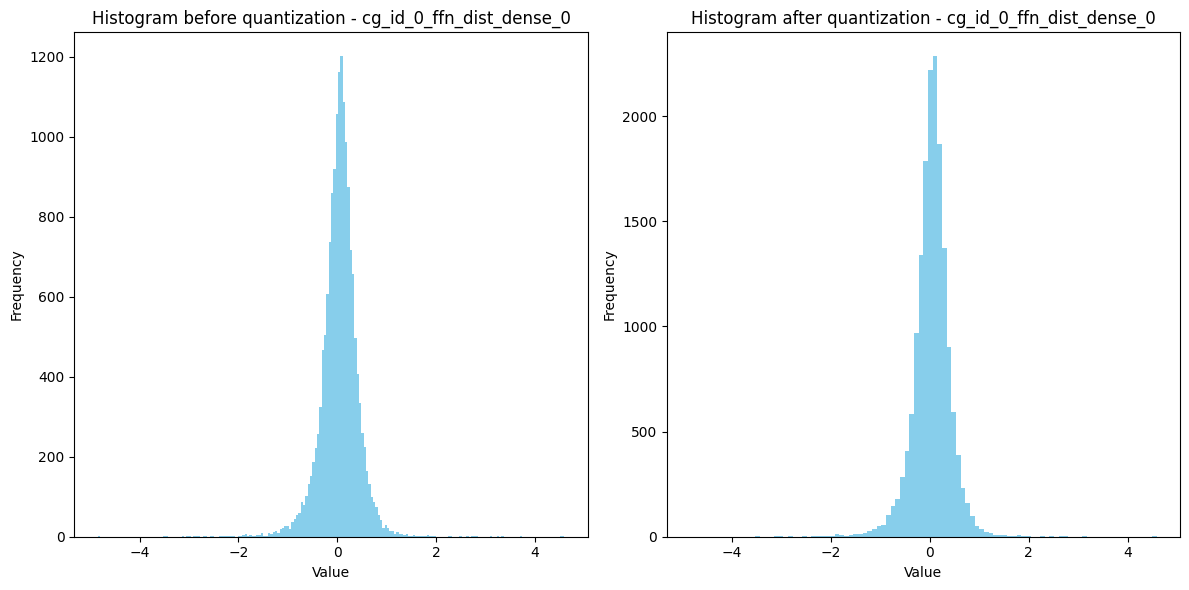

Output with Float 16 Quantization
Subgroup Name: cg_id_0_ffn_dist_dense_0
Original Bias Size: 368 bytes
Original Kernel Size: 65664 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 2.1904761904761907x
Reduction Factor for Kernel: 390.85714285714283x



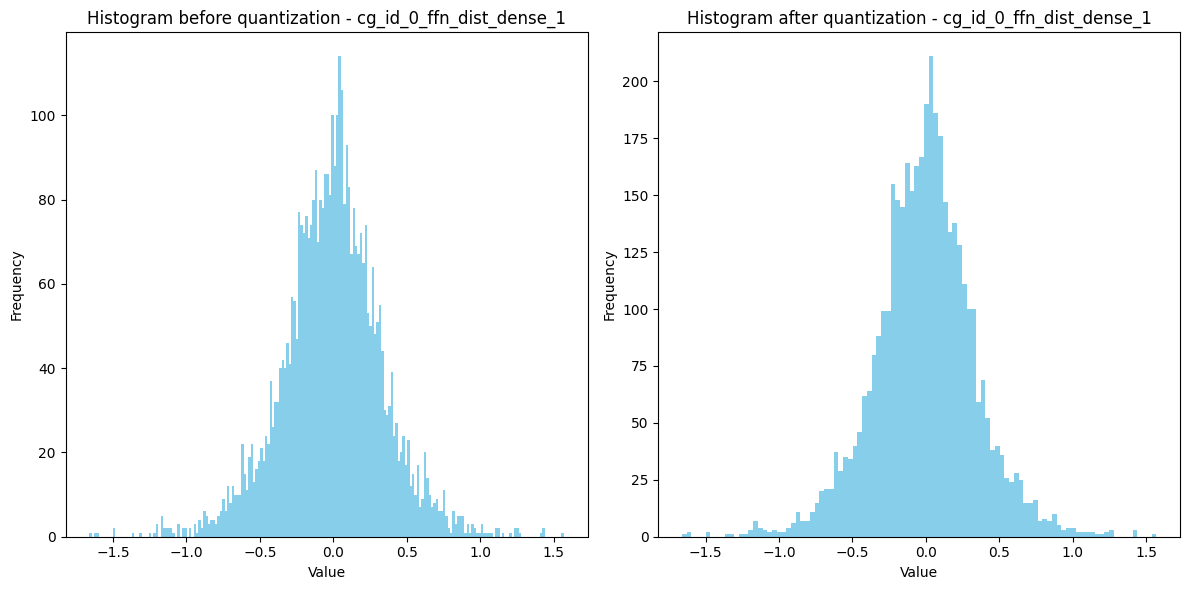

Output with Float 16 Quantization
Subgroup Name: cg_id_0_ffn_dist_dense_1
Original Bias Size: 368 bytes
Original Kernel Size: 16512 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 2.1904761904761907x
Reduction Factor for Kernel: 98.28571428571429x



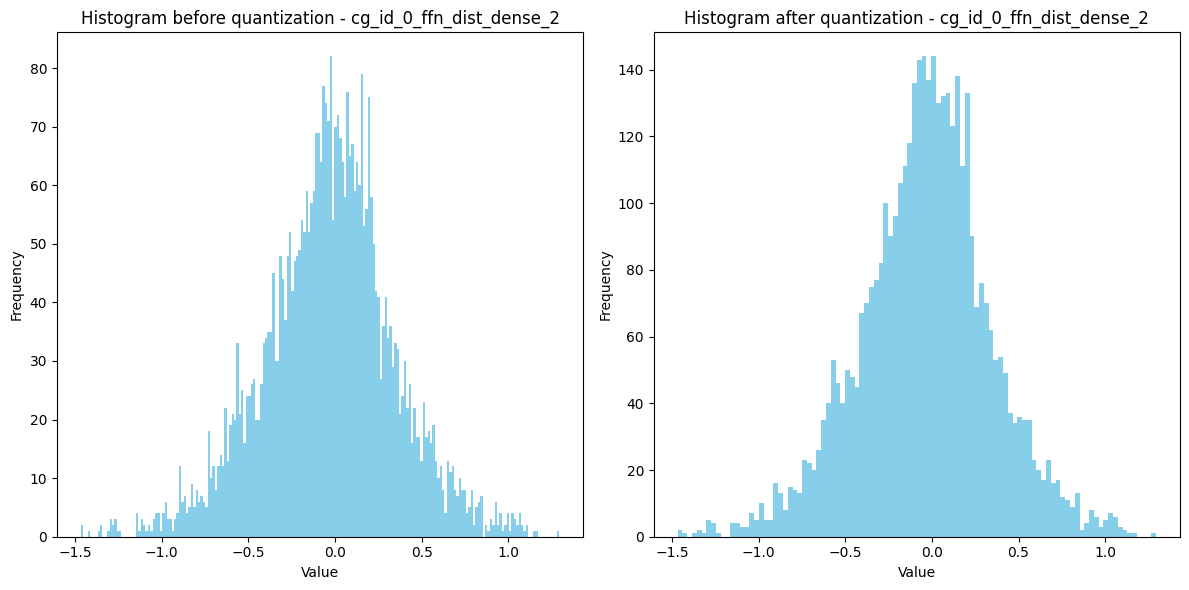

Output with Float 16 Quantization
Subgroup Name: cg_id_0_ffn_dist_dense_2
Original Bias Size: 368 bytes
Original Kernel Size: 16512 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 2.1904761904761907x
Reduction Factor for Kernel: 98.28571428571429x



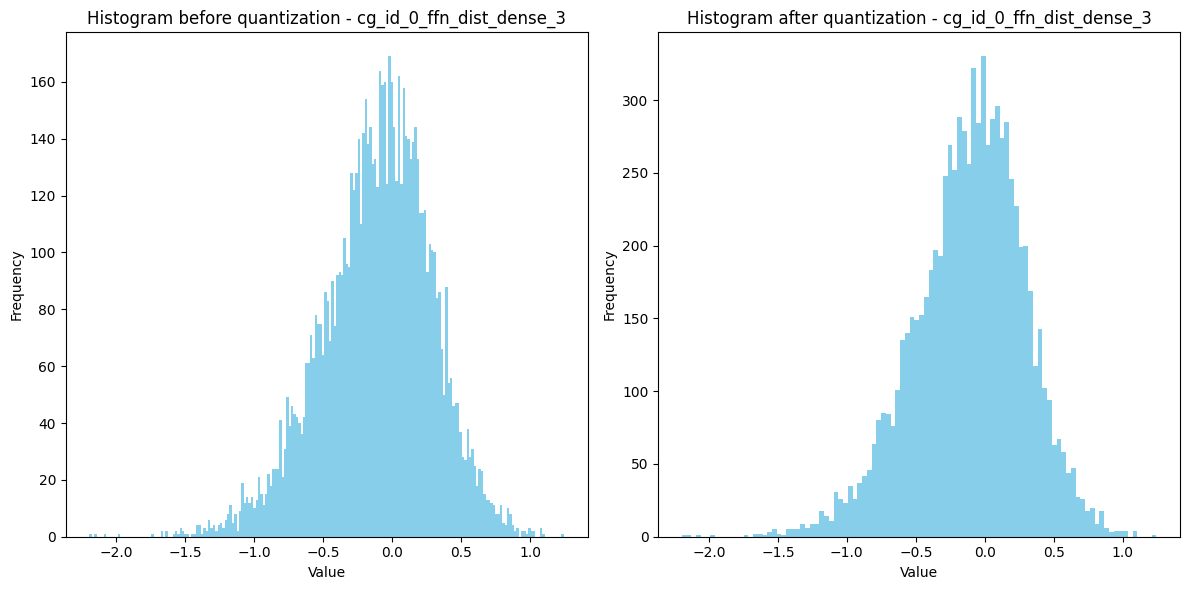

Output with Float 16 Quantization
Subgroup Name: cg_id_0_ffn_dist_dense_3
Original Bias Size: 624 bytes
Original Kernel Size: 32896 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 3.7142857142857144x
Reduction Factor for Kernel: 195.8095238095238x

Total Original Bias Size: 1728 bytes
Total Original Kernel Size: 131584 bytes
Total Quantized Bias Size: 672 bytes
Total Quantized Kernel Size: 672 bytes
Total Original Size: 133312 bytes
Total Quantized Size: 1344 bytes
Reduction Factor: 99.19047619047619x


In [89]:
import h5py
import tensorflow as tf
import sys
import numpy as np
import matplotlib.pyplot as plt

# Define a function to apply Float16 quantization
def float16_quantization(weights):
    return tf.dtypes.cast(weights, tf.float16)

# Define a function to get the size of an object in bytes
def get_size(obj):
    return sys.getsizeof(obj)

total_original_bias_size = 0
total_original_kernel_size = 0
total_quantized_bias_size = 0
total_quantized_kernel_size = 0

# Open the HDF5 file
with h5py.File('weights-96-5.346523.hdf5', 'r') as file:
    # Access the group 'cg_id_0'
    group_cg_id_0 = file['cg_id_0']
    
    # Define a list of subgroup names
    subgroup_names = ['cg_id_0_ffn_dist_dense_0', 
                      'cg_id_0_ffn_dist_dense_1', 
                      'cg_id_0_ffn_dist_dense_2', 
                      'cg_id_0_ffn_dist_dense_3']
    
    for subgroup_name in subgroup_names:
        # Access the subgroup
        subgroup = group_cg_id_0[subgroup_name]
        
        # Load the weights (bias and kernel)
        bias = subgroup['bias:0'][()]  # Load bias
        kernel = subgroup['kernel:0'][()]  # Load kernel

        # Apply Float16 quantization to the weights
        float16_bias = float16_quantization(bias)
        float16_kernel = float16_quantization(kernel)

        # Print the sizes and reduction factors
        original_bias_size = get_size(bias)
        original_kernel_size = get_size(kernel)
        quantized_bias_size = get_size(float16_bias)
        quantized_kernel_size = get_size(float16_kernel)

        # Accumulate the sizes
        total_original_bias_size += original_bias_size
        total_original_kernel_size += original_kernel_size
        total_quantized_bias_size += quantized_bias_size
        total_quantized_kernel_size += quantized_kernel_size

        # Plot the histograms
        plt.figure(figsize=(12, 6))
        
        # Before quantization
        plt.subplot(1, 2, 1)
        plt.hist(kernel.flatten(), bins=200, color='skyblue')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.title(f'Histogram before quantization - {subgroup_name}')
        
        # After quantization
        plt.subplot(1, 2, 2)
        float16_kernel_array_proto = tf.make_tensor_proto(float16_kernel)
        float16_kernel_array = tf.make_ndarray(float16_kernel_array_proto)
        plt.hist(float16_kernel_array.flatten(), bins=100, color='skyblue')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.title(f'Histogram after quantization - {subgroup_name}')
        
        plt.tight_layout()
        plt.show()
        
        # Print other information
        print(f"Output with Float 16 Quantization")
        print(f"=====================================")
        print(f"Subgroup Name: {subgroup_name}")
        print(f"Original Bias Size: {original_bias_size} bytes")
        print(f"Original Kernel Size: {original_kernel_size} bytes")
        print(f"Quantized Bias Size: {quantized_bias_size} bytes")
        print(f"Quantized Kernel Size: {quantized_kernel_size} bytes")
        print(f"Reduction Factor for Bias: {original_bias_size / quantized_bias_size}x")
        print(f"Reduction Factor for Kernel: {original_kernel_size / quantized_kernel_size}x")
        print('======================')
        print()

# Calculate total sizes
total_original_size = total_original_bias_size + total_original_kernel_size
total_quantized_size = total_quantized_bias_size + total_quantized_kernel_size

# Print the total sizes and reduction factor
print(f"Total Original Bias Size: {total_original_bias_size} bytes")
print(f"Total Original Kernel Size: {total_original_kernel_size} bytes")
print(f"Total Quantized Bias Size: {total_quantized_bias_size} bytes")
print(f"Total Quantized Kernel Size: {total_quantized_kernel_size} bytes")
print(f"Total Original Size: {total_original_size} bytes")
print(f"Total Quantized Size: {total_quantized_size} bytes")
print(f"Reduction Factor: {total_original_size / total_quantized_size}x")



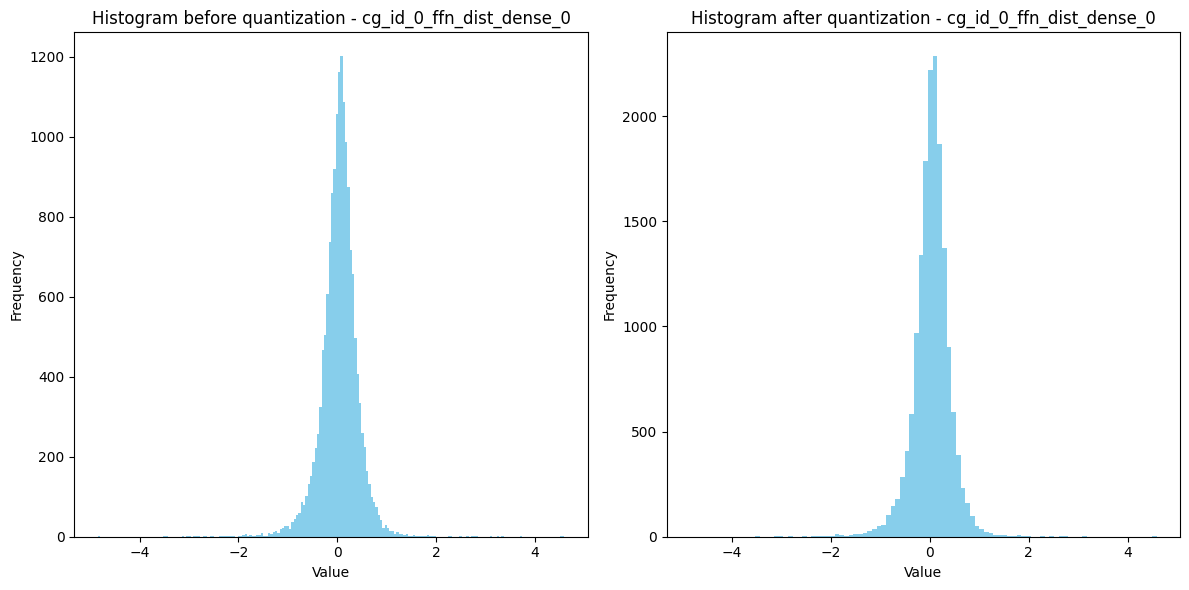

Output with Float 16 Quantization
Subgroup Name: cg_id_0_ffn_dist_dense_0
Original Bias Size: 368 bytes
Original Kernel Size: 65664 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 2.1904761904761907x
Reduction Factor for Kernel: 390.85714285714283x



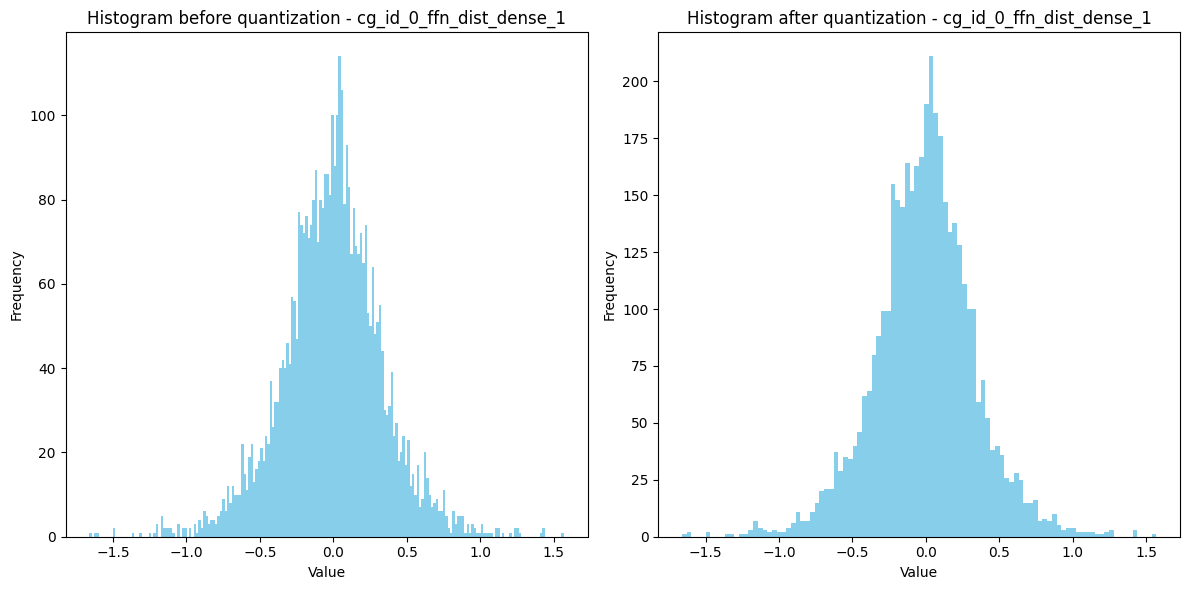

Output with Float 16 Quantization
Subgroup Name: cg_id_0_ffn_dist_dense_1
Original Bias Size: 368 bytes
Original Kernel Size: 16512 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 2.1904761904761907x
Reduction Factor for Kernel: 98.28571428571429x



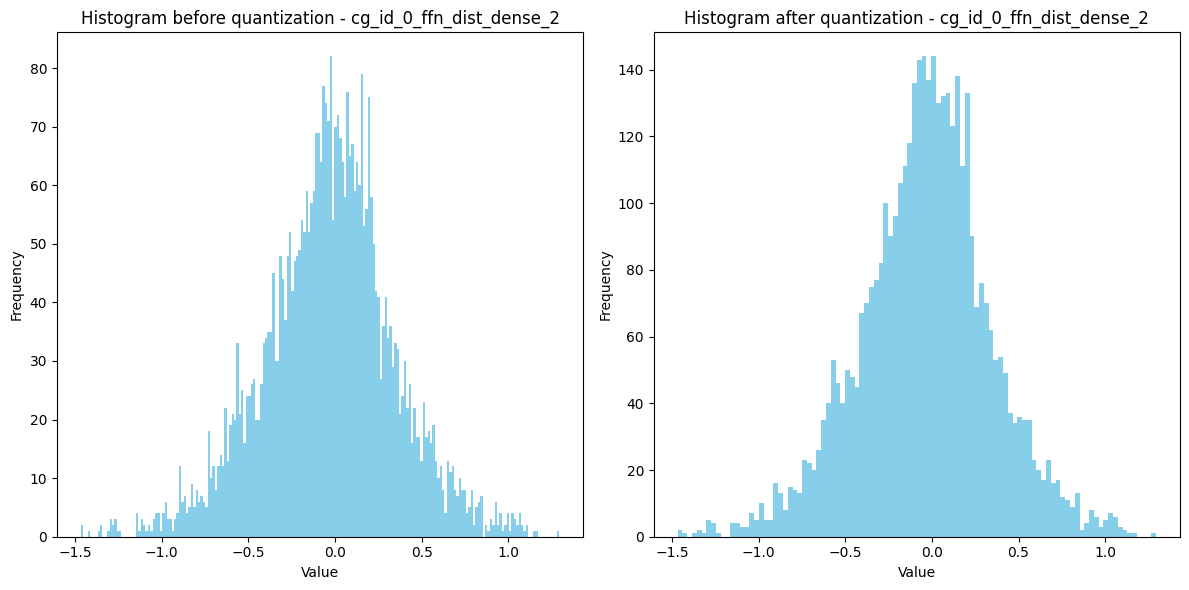

Output with Float 16 Quantization
Subgroup Name: cg_id_0_ffn_dist_dense_2
Original Bias Size: 368 bytes
Original Kernel Size: 16512 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 2.1904761904761907x
Reduction Factor for Kernel: 98.28571428571429x



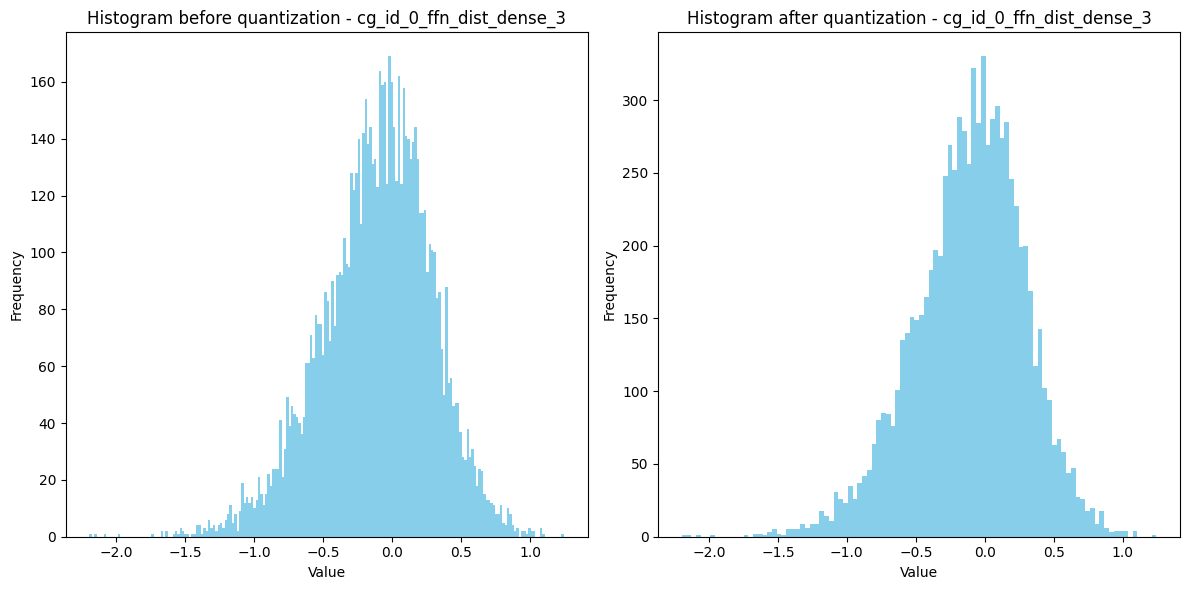

Output with Float 16 Quantization
Subgroup Name: cg_id_0_ffn_dist_dense_3
Original Bias Size: 624 bytes
Original Kernel Size: 32896 bytes
Quantized Bias Size: 168 bytes
Quantized Kernel Size: 168 bytes
Reduction Factor for Bias: 3.7142857142857144x
Reduction Factor for Kernel: 195.8095238095238x

Total Original Bias Size: 1728 bytes
Total Original Kernel Size: 131584 bytes
Total Quantized Bias Size: 672 bytes
Total Quantized Kernel Size: 672 bytes
Total Original Size: 133312 bytes
Total Quantized Size: 1344 bytes
Reduction Factor: 99.19047619047619x


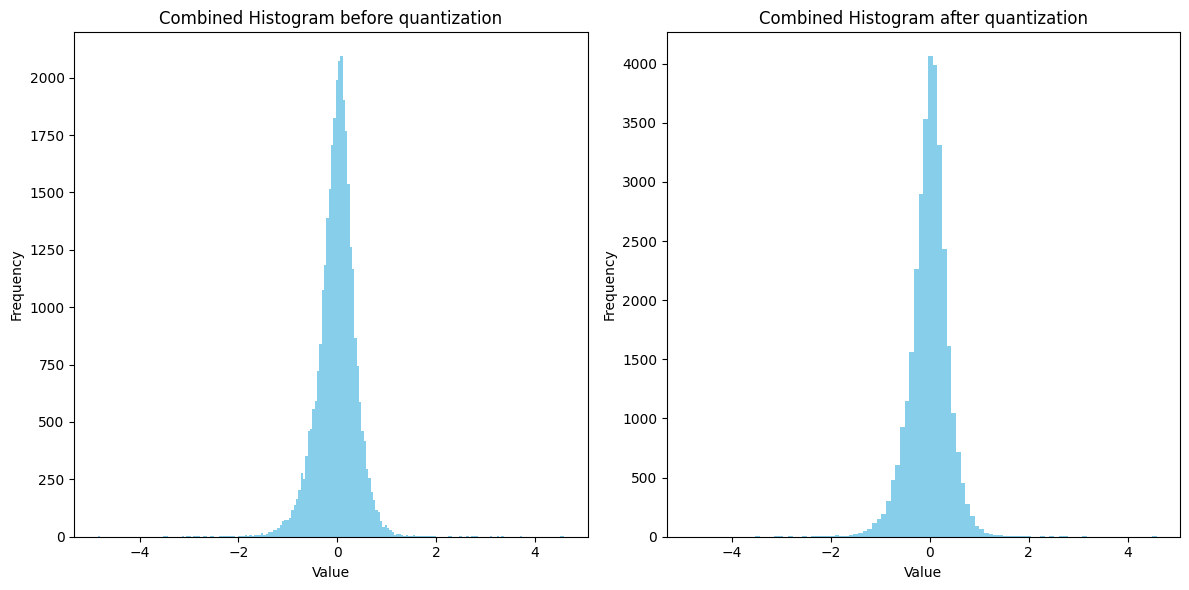

In [88]:
import h5py
import tensorflow as tf
import sys
import numpy as np
import matplotlib.pyplot as plt

# Define a function to apply Float16 quantization
def float16_quantization(weights):
    return tf.dtypes.cast(weights, tf.float16)

# Define a function to get the size of an object in bytes
def get_size(obj):
    return sys.getsizeof(obj)

total_original_bias_size = 0
total_original_kernel_size = 0
total_quantized_bias_size = 0
total_quantized_kernel_size = 0

all_original_kernel_values = []
all_quantized_kernel_values = []

# Open the HDF5 file
with h5py.File('weights-96-5.346523.hdf5', 'r') as file:
    # Access the group 'cg_id_0'
    group_cg_id_0 = file['cg_id_0']
    
    # Define a list of subgroup names
    subgroup_names = ['cg_id_0_ffn_dist_dense_0', 
                      'cg_id_0_ffn_dist_dense_1', 
                      'cg_id_0_ffn_dist_dense_2', 
                      'cg_id_0_ffn_dist_dense_3']
    
    for subgroup_name in subgroup_names:
        # Access the subgroup
        subgroup = group_cg_id_0[subgroup_name]
        
        # Load the weights (bias and kernel)
        bias = subgroup['bias:0'][()]  # Load bias
        kernel = subgroup['kernel:0'][()]  # Load kernel

        # Apply Float16 quantization to the weights
        float16_bias = float16_quantization(bias)
        float16_kernel = float16_quantization(kernel)

        # Print the sizes and reduction factors
        original_bias_size = get_size(bias)
        original_kernel_size = get_size(kernel)
        quantized_bias_size = get_size(float16_bias)
        quantized_kernel_size = get_size(float16_kernel)

        # Accumulate the sizes
        total_original_bias_size += original_bias_size
        total_original_kernel_size += original_kernel_size
        total_quantized_bias_size += quantized_bias_size
        total_quantized_kernel_size += quantized_kernel_size

        # Plot the histograms
        plt.figure(figsize=(12, 6))
        
        # Before quantization
        plt.subplot(1, 2, 1)
        plt.hist(kernel.flatten(), bins=200, color='skyblue')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.title(f'Histogram before quantization - {subgroup_name}')
        
        # After quantization
        plt.subplot(1, 2, 2)
        float16_kernel_array_proto = tf.make_tensor_proto(float16_kernel)
        float16_kernel_array = tf.make_ndarray(float16_kernel_array_proto)
        plt.hist(float16_kernel_array.flatten(), bins=100, color='skyblue')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.title(f'Histogram after quantization - {subgroup_name}')
        
        plt.tight_layout()
        plt.show()
        
        # Store kernel values for final combined plot
        all_original_kernel_values.extend(kernel.flatten())
        all_quantized_kernel_values.extend(float16_kernel_array.flatten())
        
        print(f"Output with Float 16 Quantization")
        print(f"=====================================")
        print(f"Subgroup Name: {subgroup_name}")
        print(f"Original Bias Size: {original_bias_size} bytes")
        print(f"Original Kernel Size: {original_kernel_size} bytes")
        print(f"Quantized Bias Size: {quantized_bias_size} bytes")
        print(f"Quantized Kernel Size: {quantized_kernel_size} bytes")
        print(f"Reduction Factor for Bias: {original_bias_size / quantized_bias_size}x")
        print(f"Reduction Factor for Kernel: {original_kernel_size / quantized_kernel_size}x")
        print('======================')
        print()

# Calculate total sizes
total_original_size = total_original_bias_size + total_original_kernel_size
total_quantized_size = total_quantized_bias_size + total_quantized_kernel_size

# Print the total sizes and reduction factor
print(f"Total Original Bias Size: {total_original_bias_size} bytes")
print(f"Total Original Kernel Size: {total_original_kernel_size} bytes")
print(f"Total Quantized Bias Size: {total_quantized_bias_size} bytes")
print(f"Total Quantized Kernel Size: {total_quantized_kernel_size} bytes")
print(f"Total Original Size: {total_original_size} bytes")
print(f"Total Quantized Size: {total_quantized_size} bytes")
print(f"Reduction Factor: {total_original_size / total_quantized_size}x")

# Plot the final combined histograms
plt.figure(figsize=(12, 6))

# Before quantization
plt.subplot(1, 2, 1)
plt.hist(all_original_kernel_values, bins=200, color='skyblue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Combined Histogram before quantization')

# After quantization
plt.subplot(1, 2, 2)
plt.hist(all_quantized_kernel_values, bins=100, color='skyblue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Combined Histogram after quantization')

plt.tight_layout()
plt.show()


### int8 Quantization

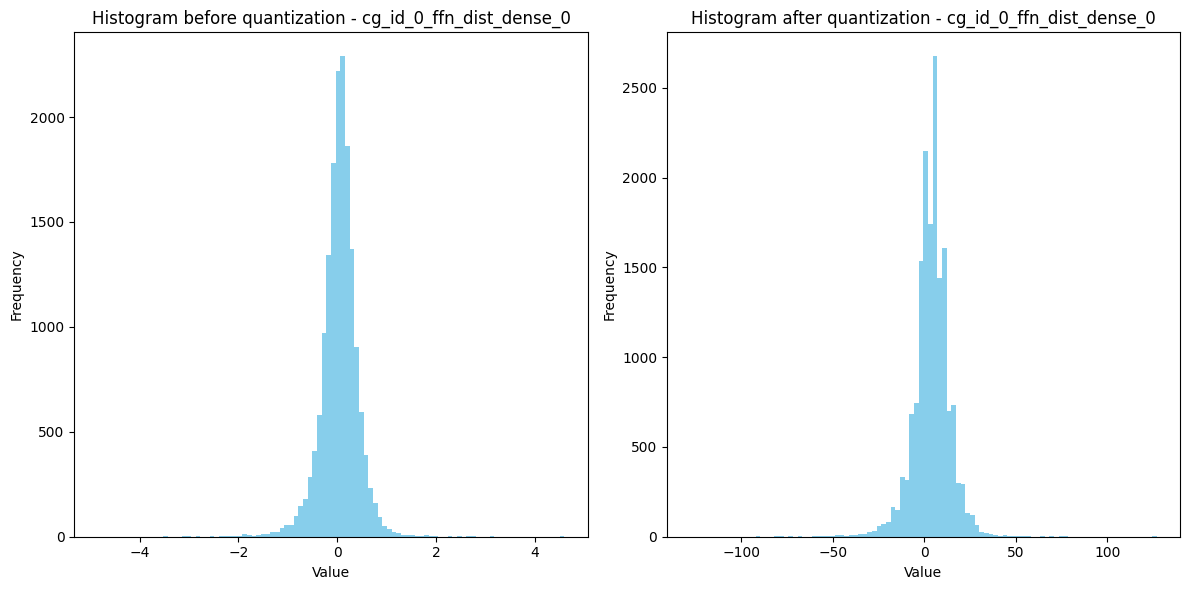

Output with Float 16 Quantization
Subgroup Name: cg_id_0_ffn_dist_dense_0
Original Bias Size: 368 bytes
Original Kernel Size: 65664 bytes
Quantized Bias Size: 64 bytes
Quantized Kernel Size: 64 bytes
Reduction Factor for Bias: 5.75x
Reduction Factor for Kernel: 1026.0x



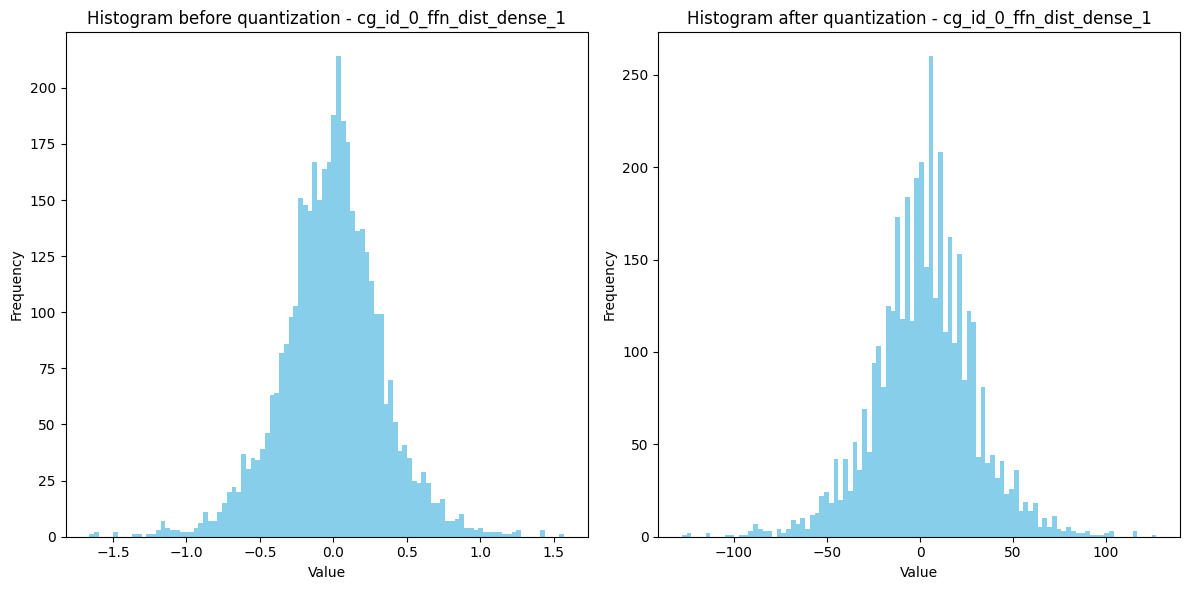

Output with Float 16 Quantization
Subgroup Name: cg_id_0_ffn_dist_dense_1
Original Bias Size: 368 bytes
Original Kernel Size: 16512 bytes
Quantized Bias Size: 64 bytes
Quantized Kernel Size: 64 bytes
Reduction Factor for Bias: 5.75x
Reduction Factor for Kernel: 258.0x



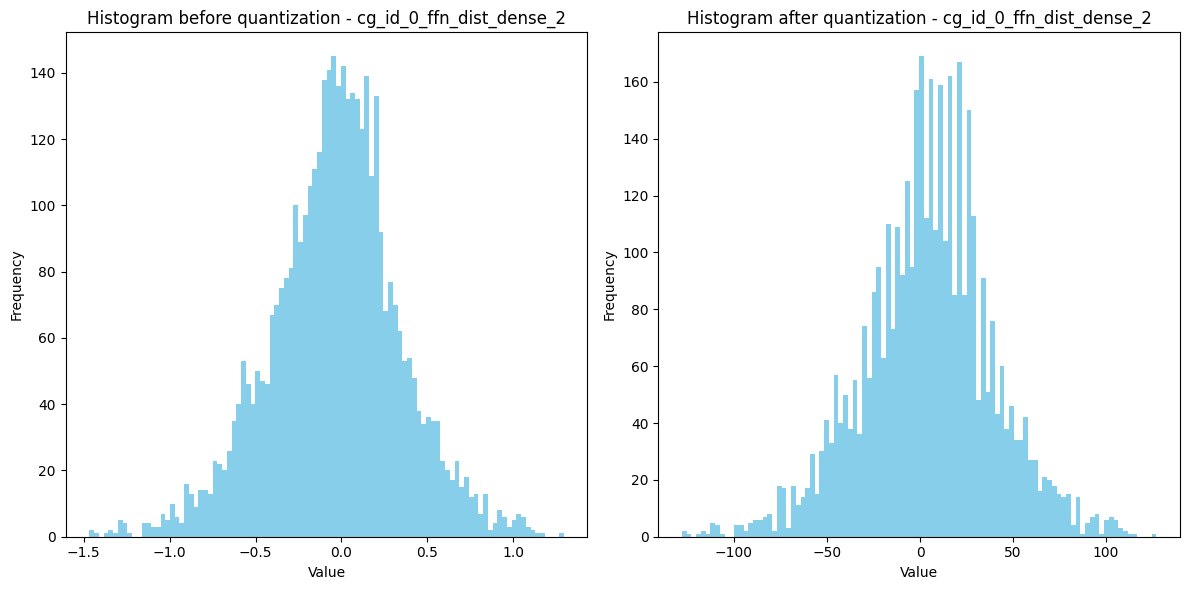

Output with Float 16 Quantization
Subgroup Name: cg_id_0_ffn_dist_dense_2
Original Bias Size: 368 bytes
Original Kernel Size: 16512 bytes
Quantized Bias Size: 64 bytes
Quantized Kernel Size: 64 bytes
Reduction Factor for Bias: 5.75x
Reduction Factor for Kernel: 258.0x



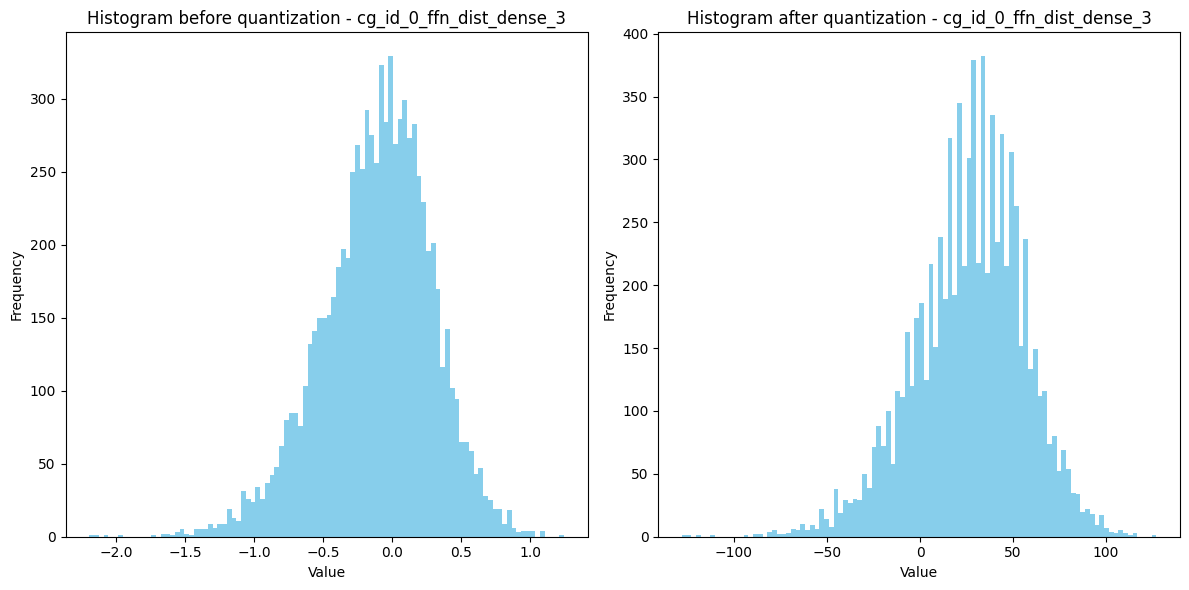

Output with Float 16 Quantization
Subgroup Name: cg_id_0_ffn_dist_dense_3
Original Bias Size: 624 bytes
Original Kernel Size: 32896 bytes
Quantized Bias Size: 64 bytes
Quantized Kernel Size: 64 bytes
Reduction Factor for Bias: 9.75x
Reduction Factor for Kernel: 514.0x

Total Original Bias Size: 1728 bytes
Total Original Kernel Size: 131584 bytes
Total Quantized Bias Size: 256 bytes
Total Quantized Kernel Size: 256 bytes
Total Original Size: 133312 bytes
Total Quantized Size: 512 bytes
Reduction Factor: 260.375x


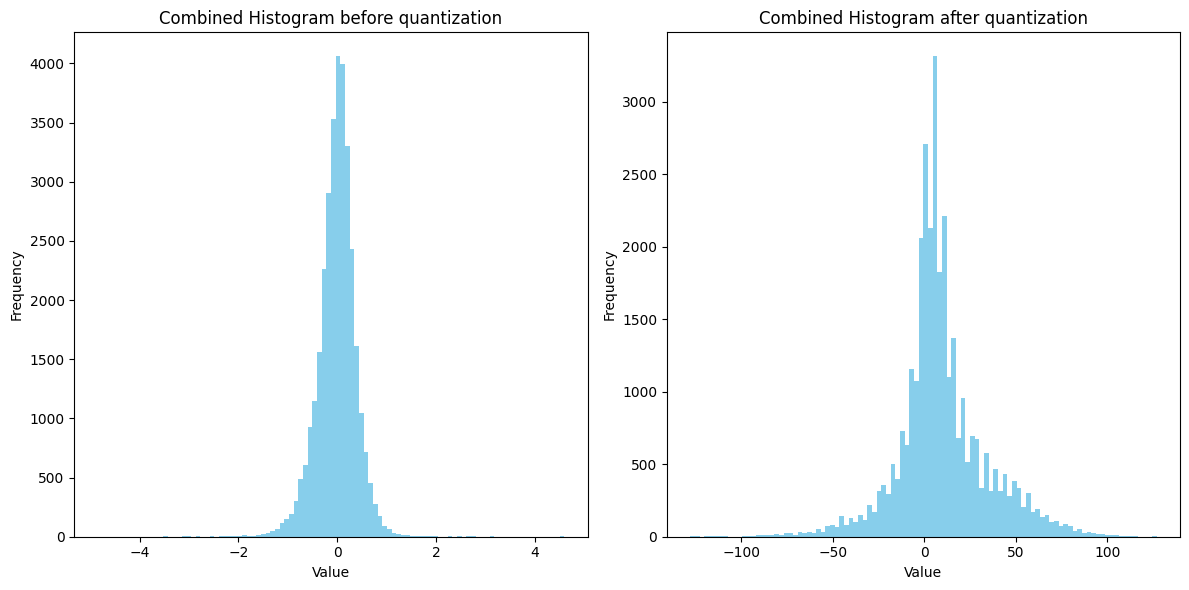

In [90]:
import h5py
import tensorflow as tf
import sys
import numpy as np
import matplotlib.pyplot as plt

# Define a function to apply Int8 quantization
def int8_quantization(weights):
    min_val = tf.reduce_min(weights)
    max_val = tf.reduce_max(weights)
    quantized_weights = tf.quantization.quantize(weights, min_val, max_val, tf.qint8)
    return quantized_weights


# Define a function to get the size of an object in bytes
def get_size(obj):
    return sys.getsizeof(obj)

total_original_bias_size = 0
total_original_kernel_size = 0
total_quantized_bias_size = 0
total_quantized_kernel_size = 0

all_original_kernel_values = []
all_quantized_kernel_values = []

# Open the HDF5 file
with h5py.File('weights-96-5.346523.hdf5', 'r') as file:
    # Access the group 'cg_id_0'
    group_cg_id_0 = file['cg_id_0']
    
    # Define a list of subgroup names
    subgroup_names = ['cg_id_0_ffn_dist_dense_0', 
                      'cg_id_0_ffn_dist_dense_1', 
                      'cg_id_0_ffn_dist_dense_2', 
                      'cg_id_0_ffn_dist_dense_3']
    
    for subgroup_name in subgroup_names:
        # Access the subgroup
        subgroup = group_cg_id_0[subgroup_name]
        
        # Load the weights (bias and kernel)
        bias = subgroup['bias:0'][()]  # Load bias
        kernel = subgroup['kernel:0'][()]  # Load kernel

        # Apply Float16 quantization to the weights
        float16_bias = int8_quantization(bias)
        float16_kernel = int8_quantization(kernel)

        # Print the sizes and reduction factors
        original_bias_size = get_size(bias)
        original_kernel_size = get_size(kernel)
        quantized_bias_size = get_size(float16_bias)
        quantized_kernel_size = get_size(float16_kernel)

        # Accumulate the sizes
        total_original_bias_size += original_bias_size
        total_original_kernel_size += original_kernel_size
        total_quantized_bias_size += quantized_bias_size
        total_quantized_kernel_size += quantized_kernel_size

        # Plot the histograms
        plt.figure(figsize=(12, 6))
        
        # Before quantization
        plt.subplot(1, 2, 1)
        plt.hist(kernel.flatten(), bins=100, color='skyblue')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.title(f'Histogram before quantization - {subgroup_name}')
        
        # After quantization
        plt.subplot(1, 2, 2)
        float16_kernel_array_proto = tf.make_tensor_proto(float16_kernel[0])
        float16_kernel_array = tf.make_ndarray(float16_kernel_array_proto)
        plt.hist(float16_kernel_array.flatten(), bins=100, color='skyblue')
        plt.xlabel('Value')
        plt.ylabel('Frequency')
        plt.title(f'Histogram after quantization - {subgroup_name}')
        
        plt.tight_layout()
        plt.show()
        
        # Store kernel values for final combined plot
        all_original_kernel_values.extend(kernel.flatten())
        all_quantized_kernel_values.extend(float16_kernel_array.flatten())
        
        print(f"Output with Float 16 Quantization")
        print(f"=====================================")
        print(f"Subgroup Name: {subgroup_name}")
        print(f"Original Bias Size: {original_bias_size} bytes")
        print(f"Original Kernel Size: {original_kernel_size} bytes")
        print(f"Quantized Bias Size: {quantized_bias_size} bytes")
        print(f"Quantized Kernel Size: {quantized_kernel_size} bytes")
        print(f"Reduction Factor for Bias: {original_bias_size / quantized_bias_size}x")
        print(f"Reduction Factor for Kernel: {original_kernel_size / quantized_kernel_size}x")
        print('======================')
        print()

# Calculate total sizes
total_original_size = total_original_bias_size + total_original_kernel_size
total_quantized_size = total_quantized_bias_size + total_quantized_kernel_size

# Print the total sizes and reduction factor
print(f"Total Original Bias Size: {total_original_bias_size} bytes")
print(f"Total Original Kernel Size: {total_original_kernel_size} bytes")
print(f"Total Quantized Bias Size: {total_quantized_bias_size} bytes")
print(f"Total Quantized Kernel Size: {total_quantized_kernel_size} bytes")
print(f"Total Original Size: {total_original_size} bytes")
print(f"Total Quantized Size: {total_quantized_size} bytes")
print(f"Reduction Factor: {total_original_size / total_quantized_size}x")

# Plot the final combined histograms
plt.figure(figsize=(12, 6))

# Before quantization
plt.subplot(1, 2, 1)
plt.hist(all_original_kernel_values, bins=100, color='skyblue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Combined Histogram before quantization')

# After quantization
plt.subplot(1, 2, 2)
plt.hist(all_quantized_kernel_values, bins=100, color='skyblue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Combined Histogram after quantization')

plt.tight_layout()
plt.show()


## Coclusion:
1. Figure out the mistakes.

    Just increase the number of bins. 
    
2. See what could be the going wrong here
    1. the histogram before quantization is between x=(-2,2) but after quantization why it's going to (-100,100)
    2. 4-bit quantization
    3. Apply to full model
    

![images](https://files.slack.com/files-tmb/T6RPRPG92-F062612REQ4-d6f5b2dfdf/image_720.png)